## Final Project: Fire detection
## Team members: Boliang Liu, Huidong Xu

In [96]:
import os
import cv2
import time
import math
import random

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models

# data augmentation
import albumentations as A

# pretrained models
import torchvision
from torchvision import models, transforms
from albumentations.pytorch import ToTensorV2

# model performance
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

## Utilities

In [97]:
def processing_unit():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    return device


def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]


# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)


def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)


def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)


def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))
    
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [98]:
# create a dataframe for our image data
data_path = 'fire_dataset/fire_images'
rows = []
for image_name in os.listdir(data_path):
    if image_name.endswith('.png'):
        row = dict()
        row['image_path'] = data_path+f'/{image_name}'
        row['label'] = 'fire'
        rows.append(row)
    
data_path_2 = 'fire_dataset/non_fire_images'
for image_name in os.listdir(data_path_2):
    if image_name.endswith('.png'):
        row = dict()
        row['image_path'] = data_path_2+f'/{image_name}'
        row['label'] = 'non_fire'
        rows.append(row)
    
df = pd.DataFrame(rows)
print(len(df))
df.head()

998


,image_path,label
0,fire_dataset/fire_images/fire.753.png,fire
1,fire_dataset/fire_images/fire.12.png,fire
2,fire_dataset/fire_images/fire.747.png,fire
3,fire_dataset/fire_images/fire.592.png,fire
4,fire_dataset/fire_images/fire.586.png,fire


## Resize image

In [99]:
# only run once
# def resize_img(path, size):
#     try:
#         img = cv2.imread(path)
#         img = cv2.resize(img, size)
#         cv2.imwrite(path, img)
#     except:
#         return path

# # resize all of the images to 256x256
# total_time_resize = 0.0
# for idx in tqdm(range(len(df))):
#     row = df.iloc[idx]
#     image_path = row['image_path']
    
#     resize_img(image_path, (256, 256))
    

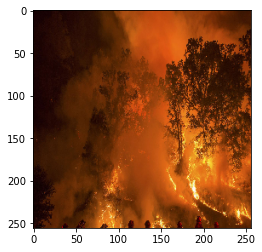

In [100]:
path = 'fire_dataset/fire_images/fire.753.png'
im = read_image(path)
plt.imshow(im)

# Define dataset

In [101]:
class FireDataset(Dataset):
    def __init__(self, df, transform=False): 
        self.df = df
        self.transform = transform
         # label dictionary
        self.label_dict = {'fire':1, 'non_fire':0}

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        # target
        label = torch.tensor(self.label_dict[row['label']])
        
        # image data
        path = str(row["image_path"])         
        ## divide RGB max value 
        x = read_image(path)/255 
        
        if self.transform:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            x = random_crop(x)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
        else:
            x = center_crop(x)
        x = normalize(x) # normalize according to imagenet stats  
        
        return np.rollaxis(x, 2), label[None]

## Split train, valid and test set

In [105]:
np.random.seed(3)
mask = np.random.random(len(df))
train_labels = df[mask <= 0.6].copy()
valid_labels = df[(mask > 0.6) & (mask <= 0.8)].copy()
test_labels = df[mask > 0.8].copy()

In [106]:
train_ds = FireDataset(df=train_labels, transform=True)
valid_ds = FireDataset(df=valid_labels)
test_ds = FireDataset(df=test_labels)

batch_size = 64 # might need to decreaase depending on gpu
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=batch_size)

(3, 240, 240)


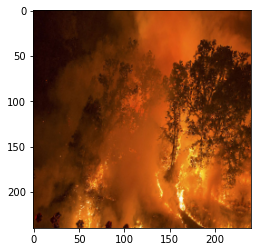

In [108]:
img, label = next(iter(train_ds))
print(img.shape)

# restructure for plt
img = np.transpose(np.array(img), (1,2,0))

# reverse the normalization
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
for i in range(3):
    img[:,:,i] = (img[:,:,i] * std[i]) + mean[i]

plt.imshow(img)

## Define model

In [120]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 1))
        
    def forward(self, image_inputs):
        x = self.features1(image_inputs)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [121]:
def train_one_epoch(model, optimizer, train_dl):
    model.train()
    total = 0
    sum_loss = 0
    #can be all put into gpu 
    for x, y in train_dl:
        batch = y.shape[0]
        x = x.float()#to(device).float()
        y = y.float()#to(device).float()
        out = model(x)
        loss = F.binary_cross_entropy_with_logits(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total

In [125]:
def train_epochs(model, train_dl, valid_dl, optimizer, epochs = 5, model_name="resnet34"):
    PATH = Path(os.getcwd())
    prev_val_loss, val_acc = val_metrics(model, valid_dl)
    for i in range(epochs):
        train_loss = train_one_epoch(model, optimizer, train_dl)
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_loss < prev_val_loss: 
            prev_val_loss = val_loss
            path = "{0}/{1}/model_{2}_{3:.0f}.pth".format(PATH, model_path, model_name, 100*val_acc)
            save_model(model, path)
            print(path)
            
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    with torch.no_grad():
        for x, y in valid_dl:
            batch = y.shape[0]
            x = x.float()#to(device).float()
            y = y #.to(device)
            out = model(x)
            pred = (out > 0.0).long() # equivalent to bigger than 0.5 
            correct += pred.eq(y.data).sum().item()
            y = y.float()
            loss = F.binary_cross_entropy_with_logits(out, y)
            sum_loss += batch*(loss.item())
            total += batch
        return sum_loss/total, correct/total
    
def create_optimizer(model, lrs):
    """ Creates an optimizer with different learning rates for groups of layers"""
    params = [{'params': model.features1.parameters(), 'lr': lrs[0]},
              {'params': model.features2.parameters(), 'lr': lrs[1]},
              {'params': model.classifier.parameters(), 'lr': lrs[2]}]
    return optim.Adam(params, weight_decay=1e-5)

## Train model

In [126]:
model_path = 'model_v2'
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [127]:
model = Net()
optimizer = create_optimizer(model, [0.001/9, 0.001/3, 0.001])
train_epochs(model, train_dl, valid_dl, optimizer, epochs = 10)

train_loss 0.295 val_loss 0.056 val_acc 0.981
/Users/xuhuidong/Desktop/sp_deep_learning/final_project/model_v2/model_resnet34_98.pth
train_loss 0.067 val_loss 0.086 val_acc 0.972
train_loss 0.035 val_loss 0.128 val_acc 0.972
train_loss 0.035 val_loss 0.046 val_acc 0.986
/Users/xuhuidong/Desktop/sp_deep_learning/final_project/model_v2/model_resnet34_99.pth
train_loss 0.108 val_loss 0.061 val_acc 0.991
train_loss 0.090 val_loss 0.077 val_acc 0.972
train_loss 0.086 val_loss 0.148 val_acc 0.977
train_loss 0.035 val_loss 0.075 val_acc 0.977
train_loss 0.025 val_loss 0.057 val_acc 0.995
train_loss 0.044 val_loss 0.371 val_acc 0.870


## Evaluate model

In [129]:
! ls model_v2

model_resnet34_98.pth model_resnet34_99.pth


In [130]:
def model_evaluation(model, valid_labels):
    """Returns metrics for model evaluation - 
       misclassified instances, truepositive instances, confusion matrix, recall, precision, y, y-hat probabilty"""
    model.eval()
    valid_ds = FireDataset(df=valid_labels)
    valid_dl = DataLoader(valid_ds, batch_size=1)
    predictions_list = []
    pred_proba_list = []
    with torch.no_grad():
        for x, y in valid_dl:
            batch = y.shape[0]
            x = x.float() #.to(device).float()
            y = y #.to(device)
            out = model(x)
            pred_proba_list.append(float(out))
            pred = (out > 0.0).long()
            predictions_list.append(int(pred))

    true_predictions = valid_labels['label'].tolist()
    true_predictions = [1 if n=='fire' else 0 for n in true_predictions]

    tp = [idx for idx in range(len(predictions_list)) if
                         predictions_list[idx] == 1 and true_predictions[idx] == 1]
    truepositive_df = valid_labels.iloc[tp]

    #returns a dataframe with false negatives and false positives classifed images
    misclassified_image_idx = [idx for idx in range(len(predictions_list)) if
                               predictions_list[idx] != true_predictions[idx]]
    misclassified_df = valid_labels.iloc[misclassified_image_idx]

    #returns the confusion matrix
    confusion_matrix_results = confusion_matrix(true_predictions, predictions_list)
    recall = recall_score(true_predictions, predictions_list)
    precision = precision_score(true_predictions, predictions_list)

    return misclassified_df, truepositive_df, confusion_matrix_results, recall, precision, true_predictions, pred_proba_list

In [131]:
model = Net()
PATH = ''
best_model_path = '/Users/xuhuidong/Desktop/sp_deep_learning/final_project/model_v2/model_resnet34_99.pth'
load_model(model, best_model_path)
misclassified_df, truepositive_df, confusion_matrix_results, recall, precision, y, pred_proba_list = model_evaluation(model, valid_labels=test_labels)

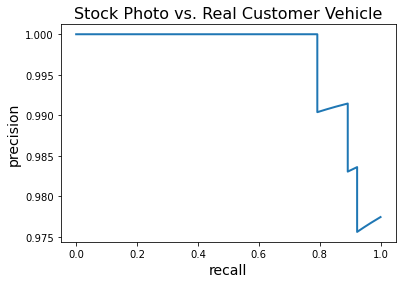

In [132]:
precision_ = dict()
recall_ = dict()
for i in range(1):
    precision_[i], recall_[i], _ = precision_recall_curve(y[:],
                                                        pred_proba_list[:])
    plt.plot(recall_[i], precision_[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall", fontsize=14)
plt.ylabel("precision", fontsize=14)
plt.title("Stock Photo vs. Real Customer Vehicle", fontsize=16)
plt.show()

In [133]:
recall, precision

(1.0, 0.9774436090225563)

In [134]:
confusion_matrix_results

array([[ 60,   3],
       [  0, 130]])